# 2D 2x2 Plate, Simple Pulling Load


In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
orig = np.array([
    [[0.125, 0.125]], [[0.375, 0.125]], [[0.625, 0.125]], [[0.875, 0.125]],
    [[0.125, 0.375]], [[0.375, 0.375]], [[0.625, 0.375]], [[0.875, 0.375]],
    [[0.125, 0.625]], [[0.375, 0.625]], [[0.625, 0.625]], [[0.875, 0.625]],
    [[0.125, 0.875]], [[0.375, 0.875]], [[0.625, 0.875]], [[0.875, 0.875]],

    [[1.125, 0.125]], [[1.375, 0.125]], [[1.625, 0.125]], [[1.875, 0.125]],
    [[1.125, 0.375]], [[1.375, 0.375]], [[1.625, 0.375]], [[1.875, 0.375]],
    [[1.125, 0.625]], [[1.375, 0.625]], [[1.625, 0.625]], [[1.875, 0.625]],
    [[1.125, 0.875]], [[1.375, 0.875]], [[1.625, 0.875]], [[1.875, 0.875]],

    [[0.125, 1.125]], [[0.375, 1.125]], [[0.625, 1.125]], [[0.875, 1.125]],
    [[0.125, 1.375]], [[0.375, 1.375]], [[0.625, 1.375]], [[0.875, 1.375]],
    [[0.125, 1.625]], [[0.375, 1.625]], [[0.625, 1.625]], [[0.875, 1.625]],
    [[0.125, 1.875]], [[0.375, 1.875]], [[0.625, 1.875]], [[0.875, 1.875]],

    [[1.125, 1.125]], [[1.375, 1.125]], [[1.625, 1.125]], [[1.875, 1.125]],
    [[1.125, 1.375]], [[1.375, 1.375]], [[1.625, 1.375]], [[1.875, 1.375]],
    [[1.125, 1.625]], [[1.375, 1.625]], [[1.625, 1.625]], [[1.875, 1.625]],
    [[1.125, 1.875]], [[1.375, 1.875]], [[1.625, 1.875]], [[1.875, 1.875]]
]
)

nodes = np.array([[0,0], [1,0], [2,0], [0,1], [1,1], [2,1], [0,2], [1,2], [2,2]])


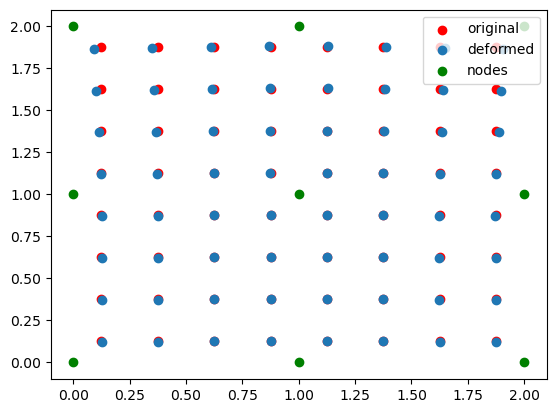

Array([ 0.0665845 , -0.06017073], dtype=float32)

In [2]:
import os
from pathlib import Path
import jax.numpy as jnp
from diffmpm import MPM




mpm = MPM("2d-plate.toml")
result = mpm.solve()

# result = jnp.load("results/uniaxial-stress-usf/particles_10.npz")

import matplotlib.pyplot as plt

plt.scatter(orig[:,:,0], orig[:,:,1], color='r', label='original')
plt.scatter(result['loc'][:,0], result['loc'][:,1], label='deformed')
plt.scatter(nodes[:,0], nodes[:,1], color='g', label = 'nodes')
plt.legend()
plt.show()

result['velocity'].squeeze()[0,:]

100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


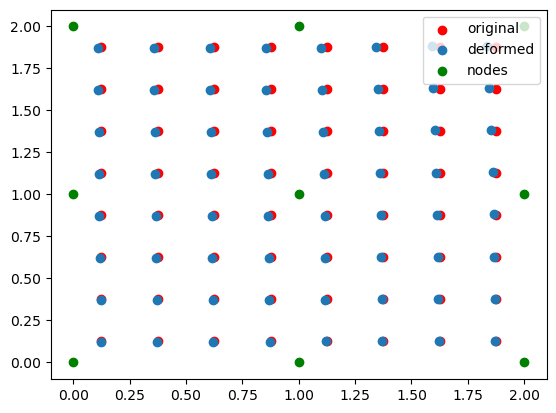

In [9]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jax import grad, jit, value_and_grad
from tqdm import tqdm
import json
import time

from diffmpm.constraint import Constraint
from diffmpm.element import Quadrilateral4Node
from diffmpm.material import LinearElastic
from diffmpm.mesh import Mesh2D
from diffmpm.particle import Particles
from diffmpm.solver import MPMExplicit
from diffmpm.functions import Linear, Unit
from diffmpm.forces import NodalForce, ParticleTraction
import diffmpm.writers as writers

# output
format = "npz"
folder = "results/"
step_frequency = 1

# material
E_true = 1000
material = LinearElastic({"youngs_modulus": E_true, "poisson_ratio" : 0, "density": 1, "id" : 0})

# particles
with open("particles-2d-uniaxial-stress.json", "r") as f:
    ploc = jnp.asarray(json.load(f))
particles = Particles(ploc, material, jnp.array([0]))

# external forces
fn = Unit(-1)
true_f1 = 0
true_f2 = -10
cnf1 = NodalForce(node_ids=[6], function=fn, dir=0, force=true_f1)
cnf2 = NodalForce(node_ids=[8], function=fn, dir=0, force=true_f2)
pst = []

# element
constraints = [(jnp.array([0]), Constraint(0, 0.0)), (jnp.array([0,1,2]), Constraint(1, 0.0))]
elements = Quadrilateral4Node(
    [2,2], 4, [1, 1], constraints, concentrated_nodal_forces=[cnf1, cnf2]
    )

# mesh
mesh = Mesh2D({
    "particles": [particles], 
    "elements": elements, 
    "particle_surface_traction" : []
    })

# scheme
dt = 0.01
nsteps = 10
mpm = MPMExplicit(
    mesh, 
    dt, 
    scheme="usl", 
    sim_steps=nsteps, 
    out_dir="results/",
    writer_func=writers.NPZWriter().write
    )
true_result = mpm.solve(0)
target_vel = true_result["velocity"]
result = jnp.array(true_result['loc'])

plt.scatter(orig[:,:,0], orig[:,:,1], color='r', label='original')
plt.scatter(result[-1,:,:,0], result[-1,:,:,1], label='deformed')
plt.scatter(nodes[:,0], nodes[:,1], color='g', label = 'nodes')
plt.legend()
plt.show()



E: 1050.0, f2: -10.012413024902344:  50%|████▉     | 497/1000 [09:44<09:48,  1.17s/it]Exception ignored in: <function _xla_gc_callback at 0x7f6a600f8180>
Traceback (most recent call last):
  File "/home/username/miniconda3/envs/env_surrogate3/lib/python3.11/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
E: 1050.0, f2: -10.008234977722168: 100%|██████████| 1000/1000 [19:25<00:00,  1.17s/it]


time:  1165.2108128070831


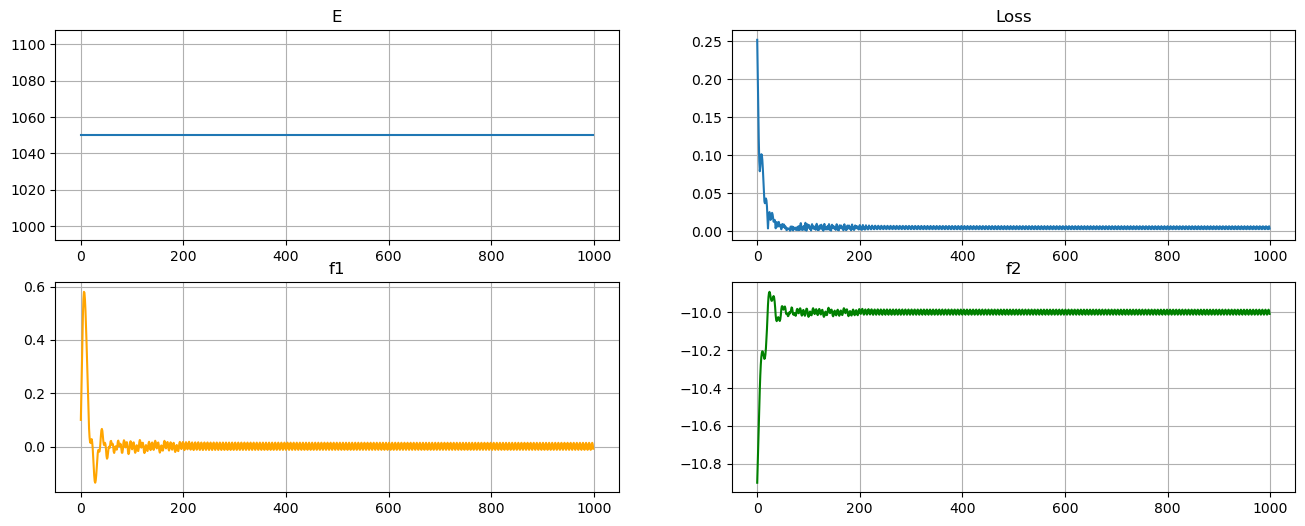

In [46]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jax import grad, jit, value_and_grad
from tqdm import tqdm
import json

from diffmpm.constraint import Constraint
from diffmpm.element import Quadrilateral4Node
from diffmpm.material import LinearElastic
from diffmpm.mesh import Mesh2D
from diffmpm.particle import Particles
from diffmpm.solver import MPMExplicit
from diffmpm.functions import Linear, Unit
from diffmpm.forces import NodalForce, ParticleTraction
import diffmpm.writers as writers
import time

# output
format = "npz"
folder = "results/"
step_frequency = 1

# material
E_true = 1000
material = LinearElastic({"youngs_modulus": E_true, "poisson_ratio" : 0, "density": 1, "id" : 0})

# particles
with open("particles-2d-uniaxial-stress.json", "r") as f:
    ploc = jnp.asarray(json.load(f))
particles = Particles(ploc, material, jnp.array([0]))

# external forces
fn = Unit(-1)
true_f1 = 0
true_f2 = -10
cnf1 = NodalForce(node_ids=[6], function=fn, dir=0, force=true_f1)
cnf2 = NodalForce(node_ids=[8], function=fn, dir=0, force=true_f2)
pst = []

# element
constraints = [(jnp.array([0]), Constraint(0, 0.0)), (jnp.array([0,1,2]), Constraint(1, 0.0))]
elements = Quadrilateral4Node(
    [2,2], 4, [1, 1], constraints, concentrated_nodal_forces=[cnf1, cnf2]
    )

# mesh
mesh = Mesh2D({
    "particles": [particles], 
    "elements": elements, 
    "particle_surface_traction" : []
    })

# scheme
dt = 0.01
nsteps = 10
mpm = MPMExplicit(
    mesh, 
    dt, 
    scheme="usl", 
    sim_steps=nsteps, 
    out_dir="results/",
    writer_func=writers.NPZWriter().write
    )
true_result = mpm.solve_jit(0)
target_vel = true_result["velocity"]

@jit 
def compute_loss(params, mpm, target_vel):
    material = LinearElastic({"youngs_modulus": params[0], "poisson_ratio" : 0, "density": 1, "id" : 0})

    # particles
    particles = Particles(ploc, material, jnp.array([0]))

    # external forces
    # fn = Unit(-1)
    cnf1 = NodalForce(node_ids=[6], function=Unit(-1), dir=0, force=params[1])
    cnf2 = NodalForce(node_ids=[8], function=Unit(-1), dir=0, force=params[2])

    # element
    # constraints = [(jnp.array([0]), Constraint(0, 0.0)), (jnp.array([0,1,2]), Constraint(1, 0.0))]
    # elements = Quadrilateral4Node(
    #     [2,2], 4, [1, 1], constraints, concentrated_nodal_forces=[cnf1, cnf2]
    #     )
    elements.concentrated_nodal_forces = [cnf1, cnf2]
    # mesh
    mesh = Mesh2D({
        "particles": [particles], 
        "elements": elements, 
        "particle_surface_traction" : []
        })

    # scheme
    mpm = MPMExplicit(
        mesh, 
        0.01, 
        scheme="usl", 
        sim_steps=nsteps, 
        out_dir="results/",
        writer_func=writers.NPZWriter().write
        )
    result = mpm.solve_jit(0)
    vel = result["velocity"]
    loss = jnp.linalg.norm(vel[:, :] - target_vel[:, :])
    return loss

def optax_adam(params, niter, ploc, target_vel):
    # Initialize parameters of the model + optimizer.
    start_learning_rate = 1e-1
    optimizer = optax.adam(start_learning_rate)
    opt_state = optimizer.init(params)

    param_list = []
    loss_list = []
    # A simple update loop.
    t = tqdm(range(niter), desc=f"E: {params[0]} f2: {params[2]}")
    for _ in t:
        lo, grads = value_and_grad(compute_loss)(params, ploc, target_vel)
        updates, opt_state = optimizer.update(grads, opt_state)
        # print("Gradients:", grads)
        # print("Updates:", updates)
        params = optax.apply_updates(params, updates)
        t.set_description(f"E: {params[0]}, f2: {params[2]}")
        param_list.append(params)
        loss_list.append(lo)
    return param_list, loss_list


params = jnp.array([1050.0, 0.0, -11.0])
# material
material = LinearElastic({"youngs_modulus": params[0], "poisson_ratio" : 0, "density": 1, "id" : 0})

# external forces
cnf1 = NodalForce(node_ids=[6], function=fn, dir=0, force=params[1])
cnf2 = NodalForce(node_ids=[8], function=fn, dir=0, force=params[2])
pst = []

# element
elements = Quadrilateral4Node(
    [2,2], 4, [1, 1], constraints, concentrated_nodal_forces=[cnf1, cnf2]
    )

# mesh
mesh = Mesh2D({
    "particles": [particles], 
    "elements": elements, 
    "particle_surface_traction" : []
    })

# scheme
dt = 0.01
nsteps = 10
mpm = MPMExplicit(
    mesh, 
    dt, 
    scheme="usl", 
    sim_steps=nsteps, 
    out_dir="results/",
    writer_func=writers.NPZWriter().write
    )
start_t = time.time()
param_list, loss_list = optax_adam(params, 5, ploc, target_vel)  # ADAM optimizer
# print("E: {}, f1: {}, f2: {}".format(param_list[-1]))
end_t = time.time()
print('time: ', end_t-start_t)
results = jnp.array(param_list)

fig, ax = plt.subplots(2, 2, figsize=(16, 6))
ax = ax.flat
ax[0].plot(results[:,0], markersize=2)
ax[0].grid()
ax[0].set_title('E')
ax[1].plot(loss_list)
ax[1].grid()
ax[1].set_title('Loss')
ax[2].plot(results[:,1], markersize=2, color='orange')
ax[2].grid()
ax[2].set_title('f1')
ax[3].plot(results[:,2], markersize=2, color='g')
ax[3].grid()
ax[3].set_title('f2')
plt.show()
# plt.savefig("../../../FEMSurrogateModelling/2D Plate Figures/output.png")

In [ ]:
fig.savefig("../../../FEMSurrogateModelling/2D Plate Figures/output.png")